<a href="https://colab.research.google.com/github/iRahulPandey/medium-articles/blob/master/Imbalanced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced Dataset
## Fraud Detection


1. Loading Data
2. Basic EDA
3. ML model
4. Trying different metrics
5. Different sampling techniques to deal with imbalanced data


## Loading Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head(n=2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


# Basic EDA

In [3]:
# check dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


There exist number of features that shows hgh difference beteen 75th percentile and MAX value which indicates that there is quite a bit of outliers in the dataset. 

**To verify that one can use BoxPlot or use IQR**

IQR = third_quantile-first_quantile <br> 
Upper_limit = third_quantile + IQR*1.5 <br> 
Lower_limit = first_quantile - IQR*1.5 <br> 

Also, features are at different scale. All models using distance method or gradient descent must have features in same scale. So scaling is required.

Maybe dropping **Time** feature in this case is a better choice.

Features from v1-v28 are the result of a PCA Dimensionality reduction to protect user identities and sensitive features

In [ ]:
# check null values
df.isnull().sum()

The dataset contains no Null values.

Now, let's check the column data type

In [ ]:
# dataset information
df.info()

Drop Time column and use Class as label.

In [18]:
# drop time column
df.pop('Time')
df.head(n=2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [32]:
# check distinct labels
df['Class'].unique()

array([0, 1])

We have 2 distinct labels as expected

0. represents Normal Transaction - Not Fraud
1. represents Fraud

Now, Let's check the class distribution

In [41]:
# Check the frequency of each class
not_fraud, fraud = np.bincount(df['Class'])
total = not_fraud + fraud
print('Class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, not_fraud, 100 * not_fraud / total, fraud, 100 * fraud / total))

Class distribution:
    Total: 284807
    Negative: 284315 (99.83% of total)
    Positive: 492 (0.17% of total)



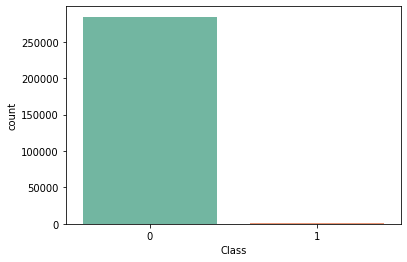

In [114]:
# plot graph
sns.countplot(x = 'Class', data=df, palette='Set2');

Extremely skewed dataset. Now let#s talk about a thing called Accuracy Paradox. We can't use accuracy in this case becuase any model without any training if only predicts majority class may result in accuracy of 99% which might not the reality.

In this case if we have Fraud (Positive) case and detected as Not-Fraud(Negative) i.e. False Negative can be very critical. However, on the other hand if we don't have fraud case and model predict fraud (False Positive), this case is also often not required because it means that due to false positive we might keep on asking costomers to verify which might be irritating for customers.

In this case we need to build a model that can minimize both FP and FN and hence f1 score can be the better metrics compared to accuracy.

NOw, lets check the correlation

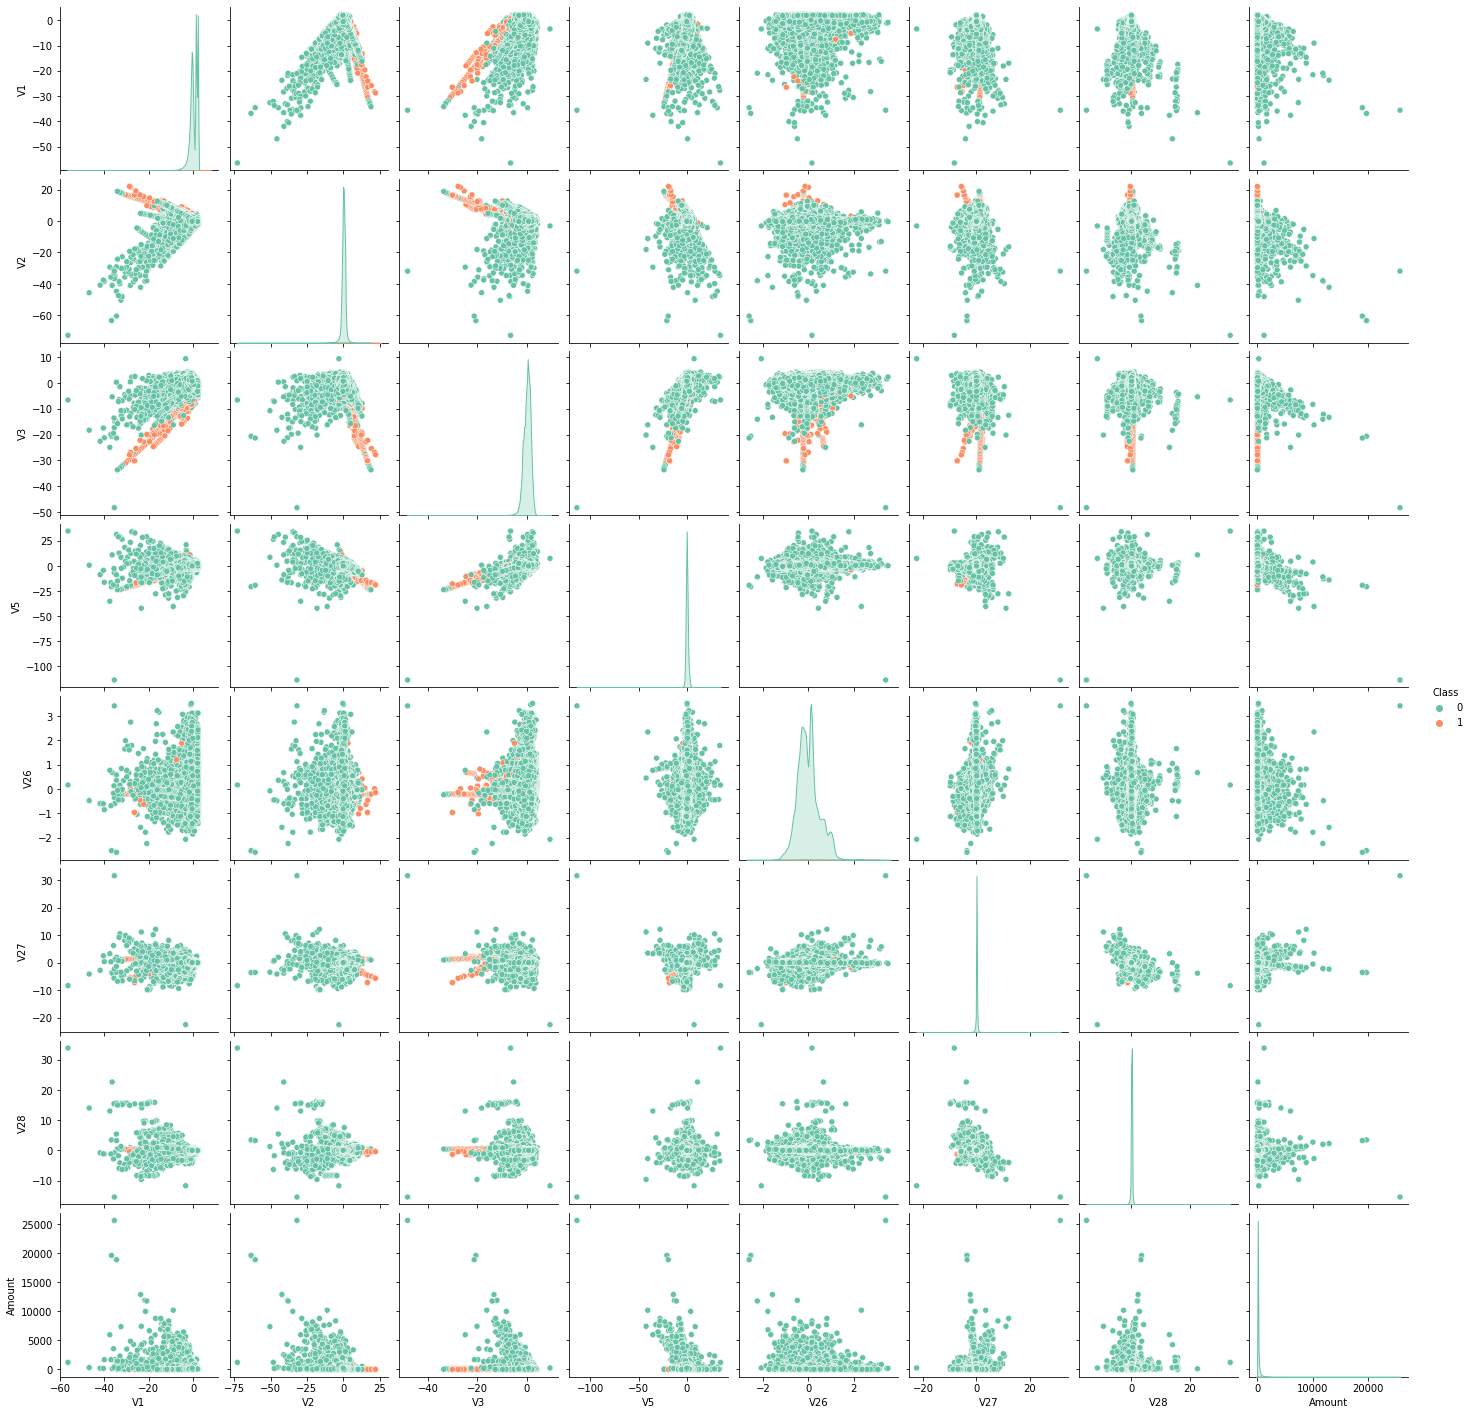

In [115]:
# some quick visualizatioon
numeric_columns = ['V1', 'V2', 'V3', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']

# pair plot to see how distribution looks
sns.pairplot(df[numeric_columns], hue='Class', palette='Set2');

Again this shows that features are not at same scale and also Amount column ranges between 0 to 10000 with some outliers.

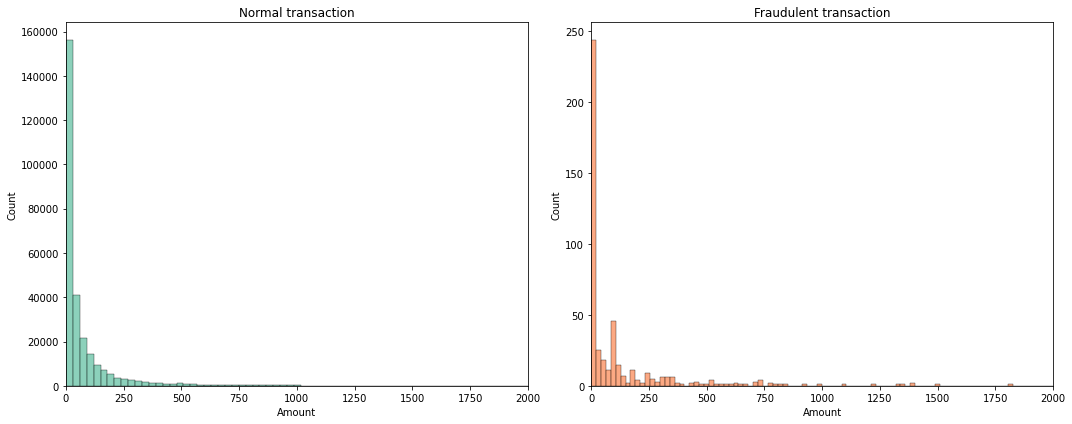

In [199]:
# check distribution of Amount
f, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw=dict(width_ratios=[4, 4]))
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==0)], x="Amount", bins=100, color='#66c2a4', ax=axs[0])
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==1)], x="Amount", bins=100, color='#fc8d59', ax=axs[1])
axs[0].set_xlim([0,2000])
axs[1].set_xlim([0,2000])
axs[0].set_title('Normal transaction')
axs[1].set_title('Fraudulent transaction')
f.tight_layout()

In [9]:
# convert Amount to log scale
# some amount is 0 and log is not defined at 0 hence add small amount
error = 0.001
df['log_Amount'] = np.log(df['Amount']+error)
df.head(n=2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,log_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008105
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989913


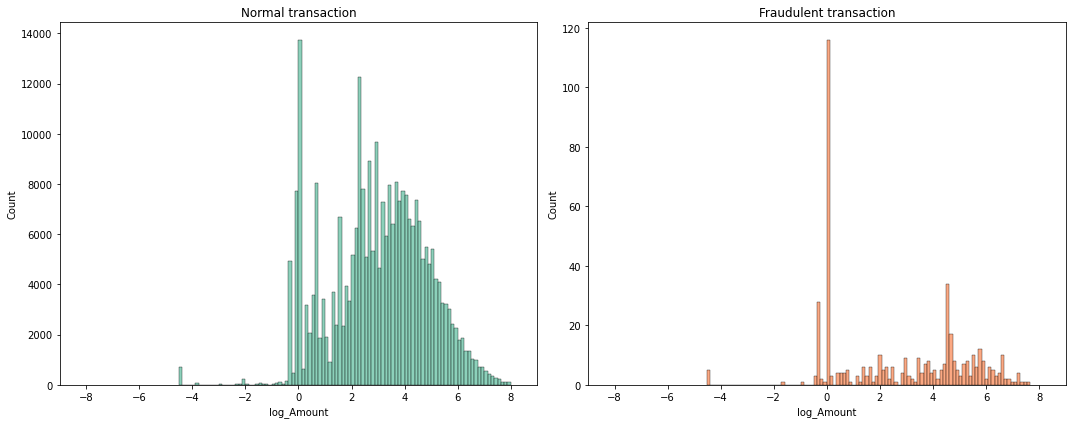

In [203]:
# check distribution of log_Amount
f, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw=dict(width_ratios=[4, 4]))
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==0)], x="log_Amount", bins=100, color='#66c2a4', ax=axs[0])
sns.histplot(df[(df.Amount<3000) & (df.Amount>0)& (df.Class==1)], x="log_Amount", bins=100, color='#fc8d59', ax=axs[1])
axs[0].set_xlim([-9,9])
axs[1].set_xlim([-9,9])
axs[0].set_title('Normal transaction')
axs[1].set_title('Fraudulent transaction')
f.tight_layout()

# Prepare Data

First we split data into train, test and validation dataset

Then we will do scaling og features followed by some jointplots 

In [170]:
from sklearn.model_selection import train_test_split

# copy data
df_copy = df.copy()

# remove the Amount
df_copy.pop('Amount')

# remove the Time
df_copy.pop('Time')

# get label
labels = df_copy.pop('Class')

# get fearues
features = df_copy

# split data into train and test
X_train_ini, X_test, y_train_ini, y_test = train_test_split(features, labels, test_size=0.1, stratify = labels, random_state=0)

# split data into train and test
X_train, X_valid, y_train, y_valid = train_test_split(X_train_ini, y_train_ini, test_size=0.2, stratify = y_train_ini, random_state=0)

In [146]:
# Check the frequency of each class in splitted data for training data
train_not_fraud, train_fraud = np.bincount(y_train)
train_total = train_not_fraud + train_fraud
print('Training class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    train_total, train_not_fraud, 100 * train_not_fraud / train_total, train_fraud, 100 * train_fraud / train_total))

Training class distribution:
    Total: 205060
    Negative: 204706 (99.83% of total)
    Positive: 354 (0.17% of total)



In [147]:
# Check the frequency of each class in splitted data for validation data
valid_not_fraud, valid_fraud = np.bincount(y_valid)
valid_total = valid_not_fraud + valid_fraud
print('Validation class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    valid_total, valid_not_fraud, 100 * valid_not_fraud / valid_total, valid_fraud, 100 * valid_fraud / valid_total))

Validation class distribution:
    Total: 51266
    Negative: 51177 (99.83% of total)
    Positive: 89 (0.17% of total)



In [148]:
# Check the frequency of each class in splitted data for test data
test_not_fraud, test_fraud = np.bincount(y_test)
test_total = test_not_fraud + test_fraud
print('Testing class distribution:\n    Total: {}\n    Negative: {} ({:.2f}% of total)\n    Positive: {} ({:.2f}% of total)\n'.format(
    test_total, test_not_fraud, 100 * test_not_fraud / test_total, test_fraud, 100 * test_fraud / test_total))

Testing class distribution:
    Total: 28481
    Negative: 28432 (99.83% of total)
    Positive: 49 (0.17% of total)



In [172]:
# scale data
from sklearn.preprocessing import StandardScaler

# create object
scalar = StandardScaler()

# fit and transform train after that clip data
X_train_Scaled = np.clip(scalar.fit_transform(X_train), -5, 5)

# transform validate after that clip data
X_valid_Scaled = np.clip(scalar.transform(X_valid), -5, 5)

# transform test after that clip data
X_test_Scaled = np.clip(scalar.transform(X_test), -5, 5)

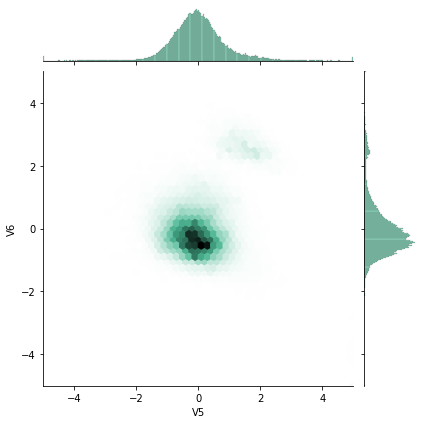

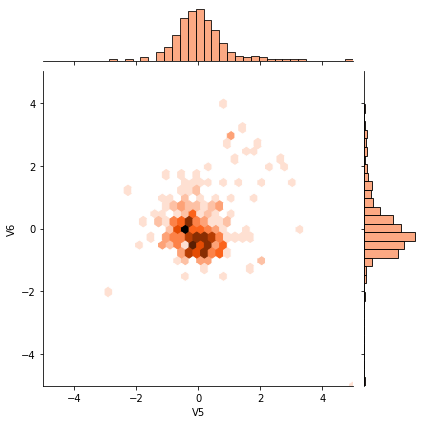

In [181]:
# create training dataframe
train_df = pd.DataFrame(data=X_train_Scaled, columns=X_train.columns)
train_df['Class'] = y_train

# check distribution using joint plot
sns.jointplot(x=train_df[(train_df.Class==0)]['V5'], y=train_df[(train_df.Class==0)]['V6'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=train_df[(train_df.Class==1)]['V5'], y=train_df[(train_df.Class==1)]['V6'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');


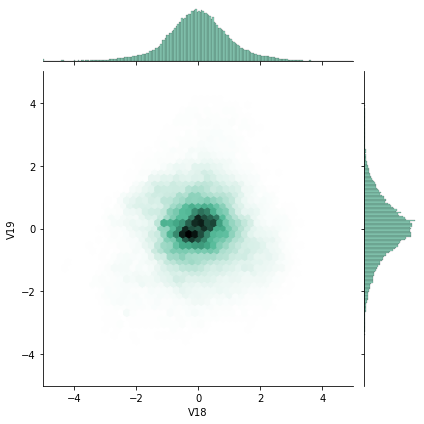

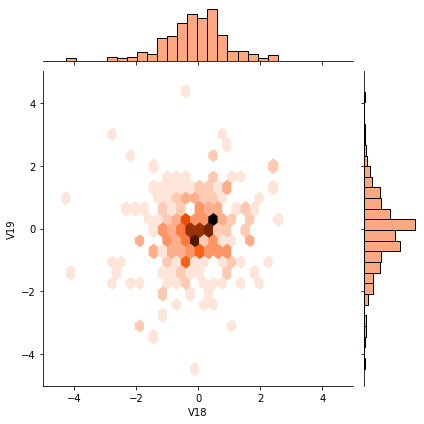

In [182]:
# check distribution using joint plot
sns.jointplot(x=train_df[(train_df.Class==0)]['V18'], y=train_df[(train_df.Class==0)]['V19'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=train_df[(train_df.Class==1)]['V18'], y=train_df[(train_df.Class==1)]['V19'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');

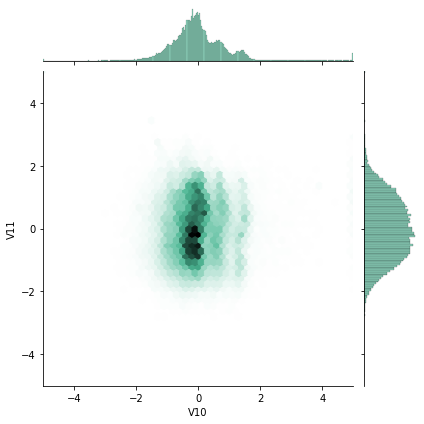

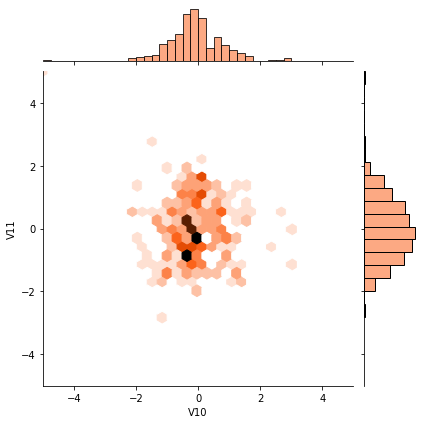

In [183]:
# check distribution using joint plot
sns.jointplot(x=train_df[(train_df.Class==0)]['V10'], y=train_df[(train_df.Class==0)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#66c2a4');
sns.jointplot(x=train_df[(train_df.Class==1)]['V10'], y=train_df[(train_df.Class==1)]['V11'], kind='hex', xlim = (-5,5), ylim = (-5,5), color='#fc8d59');

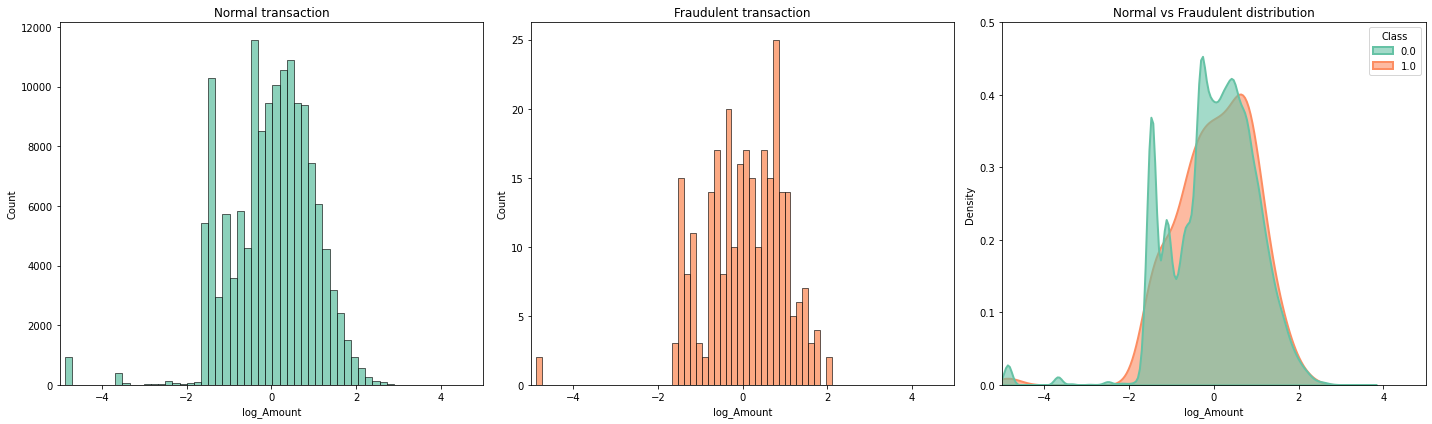

In [229]:
# check distribution of log_Amount
f, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(train_df[(train_df.Class==0)], x="log_Amount", bins=50, color='#66c2a4', ax=axs[0])
sns.histplot(train_df[(train_df.Class==1)], x="log_Amount", bins=50, color='#fc8d59', ax=axs[1])
sns.kdeplot(data=train_df, x="log_Amount", hue="Class",fill=True, common_norm=False, palette="Set2",alpha=.6, linewidth=2, ax=axs[2])
axs[0].set_title('Normal transaction')
axs[1].set_title('Fraudulent transaction')
axs[2].set_title('Normal vs Fraudulent distribution')
axs[0].set_xlim([-5,5])
axs[1].set_xlim([-5,5])
axs[2].set_xlim([-5,5])
axs[2].set_ylim([0,0.5])
f.tight_layout()

# Create Model

As stated before Accuracy won't be a good metric for Imbalanced dataset. Hence, lets explore some useful metrics.

1. Precision is the percentage of predicted positives that were correctly classified
2. Recall is the percentage of actual positives that were correctly classified
3. AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC).


In [236]:
# import important packages
import keras
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC, BinaryAccuracy
from keras.models import Model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.initializers import Constant

In [237]:
# metrics to test
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

# create the logistic model
def logistic_model(units = 15, metrics = METRICS, output_bias=None):

  # create the model
  if output_bias is not None:
    output_bias = Constant(output_bias)
  i = Input(X_train_Scaled.shape[-1],)
  x = Dense(units, activation='relu')(i)
  x = Dropout(0.2)(x)
  x = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
  model = Model(i,x)
  
  # compile the model
  model.compile(
      optimizer=Adam(lr=1e-3),
      loss=BinaryCrossentropy(),
      metrics=metrics)

  return model

In [291]:
# call function
model = logistic_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                450       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16        
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


In [292]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 2048

# model without training
results = model.evaluate(X_train_Scaled, y_train, verbose=0, batch_size=BATCH_SIZE)
print("Loss:            {:0.2f}".format(results[0]))
print("True Positive:   {:0.2f}".format(results[1]))
print("False Positive:  {:0.2f}".format(results[2]))
print("True Negative:   {:0.2f}".format(results[3]))
print("False Negative:  {:0.2f}".format(results[4]))
print("Accuracy:        {:0.2f}".format(results[5]))
print("Precision:       {:0.2f}".format(results[6]))
print("Recall:          {:0.2f}".format(results[7]))
print("AUC:             {:0.2f}".format(results[8]))

Loss:            0.84
True Positive:   356.00
False Positive:  291983.00
True Negative:   322135.00
False Negative:  706.00
Accuracy:        0.52
Precision:       0.00
Recall:          0.34
AUC:             0.53


In [293]:
# let's set teh initial bias so that model converges faaster during training
initial_bias = np.log([train_fraud/train_not_fraud])

# model with initial
model = logistic_model(output_bias = initial_bias)
results = model.evaluate(X_train_Scaled, y_train, verbose=0, batch_size=BATCH_SIZE)
print("Loss:            {:0.2f}".format(results[0]))
print("True Positive:   {:0.2f}".format(results[1]))
print("False Positive:  {:0.2f}".format(results[2]))
print("True Negative:   {:0.2f}".format(results[3]))
print("False Negative:  {:0.2f}".format(results[4]))
print("Accuracy:        {:0.2f}".format(results[5]))
print("Precision:       {:0.2f}".format(results[6]))
print("Recall:          {:0.2f}".format(results[7]))
print("AUC:             {:0.2f}".format(results[8]))

Loss:            0.01
True Positive:   356.00
False Positive:  291983.00
True Negative:   526841.00
False Negative:  1060.00
Accuracy:        0.64
Precision:       0.00
Recall:          0.25
AUC:             0.58


Save model weights and start with re-training

In [296]:
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

Create new model and initialize weights

In [304]:
# new model
model = logistic_model()

# load weight
model.load_weights(initial_weights)

# initialize bias
model.layers[-1].bias.assign([0.0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [305]:
# Fit data to model
zero_bias_history = model.fit(
    X_train_Scaled,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid_Scaled, y_valid), 
    verbose=0)

In [308]:
results = model.evaluate(X_test_Scaled, y_test, verbose=0, batch_size=BATCH_SIZE)
print("Loss:            {:0.2f}".format(results[0]))
print("True Positive:   {:0.2f}".format(results[1]))
print("False Positive:  {:0.2f}".format(results[2]))
print("True Negative:   {:0.2f}".format(results[3]))
print("False Negative:  {:0.2f}".format(results[4]))
print("Accuracy:        {:0.2f}".format(results[5]))
print("Precision:       {:0.2f}".format(results[6]))
print("Recall:          {:0.2f}".format(results[7]))
print("AUC:             {:0.2f}".format(results[8]))

Loss:            0.00
True Positive:   37.00
False Positive:  3.00
True Negative:   28429.00
False Negative:  12.00
Accuracy:        1.00
Precision:       0.93
Recall:          0.76
AUC:             0.91
